In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Load CityScore
cs = pd.read_csv('Cityscore.csv', low_memory=False)
print(f'Shape: {cs.shape}')
print(f'Columns: {list(cs.columns)}')
print(f'\nUnique metrics: {cs["metric_name"].nunique()}')
print(f'\nMetric names:\n{cs["metric_name"].value_counts()}')
print(f'\nMissing values:')
for col in cs.columns:
    pct = cs[col].isnull().sum() / len(cs) * 100
    if pct > 0:
        print(f'  {col}: {pct:.1f}%')

Shape: (65044, 17)
Columns: ['metric_name', 'score_calculated_ts', 'target', 'metric_logic', 'day_score', 'day_numerator', 'day_denominator', 'week_score', 'week_numerator', 'week_denominator', 'month_score', 'month_numerator', 'month_denominator', 'quarter_score', 'quarter_numerator', 'quarter_denominator', 'latest_score_flag']

Unique metrics: 23

Metric names:
metric_name
PARKS MAINTENANCE ON-TIME %           2898
311 CALL CENTER PERFORMANCE           2898
SIGN INSTALLATION ON-TIME %           2898
STREETLIGHT ON-TIME %                 2898
SIGNAL REPAIR ON-TIME %               2898
MISSED TRASH ON-TIME %                2898
POTHOLE ON-TIME %                     2898
311 CONSTITUENT EXPERIENCE SURVEYS    2898
TREE MAINTENANCE ON-TIME %            2897
CITY SERVICES SATISFACTION SURVEYS    2897
CODE ENFORCEMENT TRASH COLLECTION     2897
BFD RESPONSE TIME                     2897
CODE ENFORCEMENT ON-TIME %            2897
BPS ATTENDANCE                        2896
LIBRARY USERS       

In [15]:
# Parse timestamps & numeric conversion 
cs['score_calculated_ts'] = pd.to_datetime(cs['score_calculated_ts'], errors='coerce')
cs['day_score'] = pd.to_numeric(cs['day_score'], errors='coerce')

# Cap extreme outliers
print(f'Extreme day_score values (>20): {(cs["day_score"] > 20).sum()}')
cs.loc[cs['day_score'] > 20, 'day_score'] = 20.0

# Temporal features
cs['year'] = cs['score_calculated_ts'].dt.year
cs['month'] = cs['score_calculated_ts'].dt.month
cs['day_of_week'] = cs['score_calculated_ts'].dt.dayofweek
cs['is_weekend'] = cs['day_of_week'].isin([5, 6]).astype(int)

# Categorize metrics into domains
safety = ['HOMICIDES (TREND)', 'SHOOTINGS (TREND)', 'STABBINGS (TREND)', 
          'PART 1 CRIMES', 'BFD RESPONSE TIME', 'BFD INCIDENTS', 'EMS RESPONSE TIME']
infrastructure = ['POTHOLE ON-TIME %', 'STREETLIGHT ON-TIME %', 'SIGNAL REPAIR ON-TIME %',
                  'SIGN INSTALLATION ON-TIME %', 'TREE MAINTENANCE ON-TIME %', 
                  'PARKS MAINTENANCE ON-TIME %', 'GRAFFITI ON-TIME %']
services = ['311 CALL CENTER PERFORMANCE', '311 CONSTITUENT EXPERIENCE SURVEYS', 
            'MISSED TRASH ON-TIME %', 'CODE ENFORCEMENT ON-TIME %',
            'CODE ENFORCEMENT TRASH COLLECTION', 'CITY SERVICES SATISFACTION SURVEYS',
            'ON-TIME PERMIT REVIEWS']
education = ['BPS ATTENDANCE', 'LIBRARY USERS']

def categorize(m):
    m = str(m).upper().strip()
    if m in safety: return 'Safety'
    if m in infrastructure: return 'Infrastructure'
    if m in services: return 'Services'
    if m in education: return 'Education'
    return 'Other'

cs['metric_domain'] = cs['metric_name'].apply(categorize)

print('\nDomain Distribution')
domain_counts = cs['metric_domain'].value_counts()
domain_pct = cs['metric_domain'].value_counts(normalize=True) * 100
for d, p in domain_pct.items():
    flag = ' ⚠️ UNDERREPRESENTED' if p < 10 else ''
    print(f'  {d}: {domain_counts[d]} records ({p:.1f}%){flag}')

Extreme day_score values (>20): 0

Domain Distribution
  Infrastructure: 20168 records (31.0%)
  Services: 19759 records (30.4%)
  Safety: 19325 records (29.7%)
  Education: 5792 records (8.9%) ⚠️ UNDERREPRESENTED


 Kruskal-Wallis: Day Score by Metric Domain
H-statistic: 1077.3195
p-value:     0.000000
Significant: True

Domain means:
metric_domain
Safety            1.4613
Education         1.2499
Services          1.0603
Infrastructure    0.9435
Name: day_score, dtype: float64

CV: 0.1924
⚠️ MODERATE DISPARITY

Mann-Whitney U: Weekend vs Weekday
Weekday mean: 1.1351 (n=32416)
Weekend mean: 1.1510 (n=9000)
U-statistic: 140644707.00, p-value: 0.000000
Significant: True


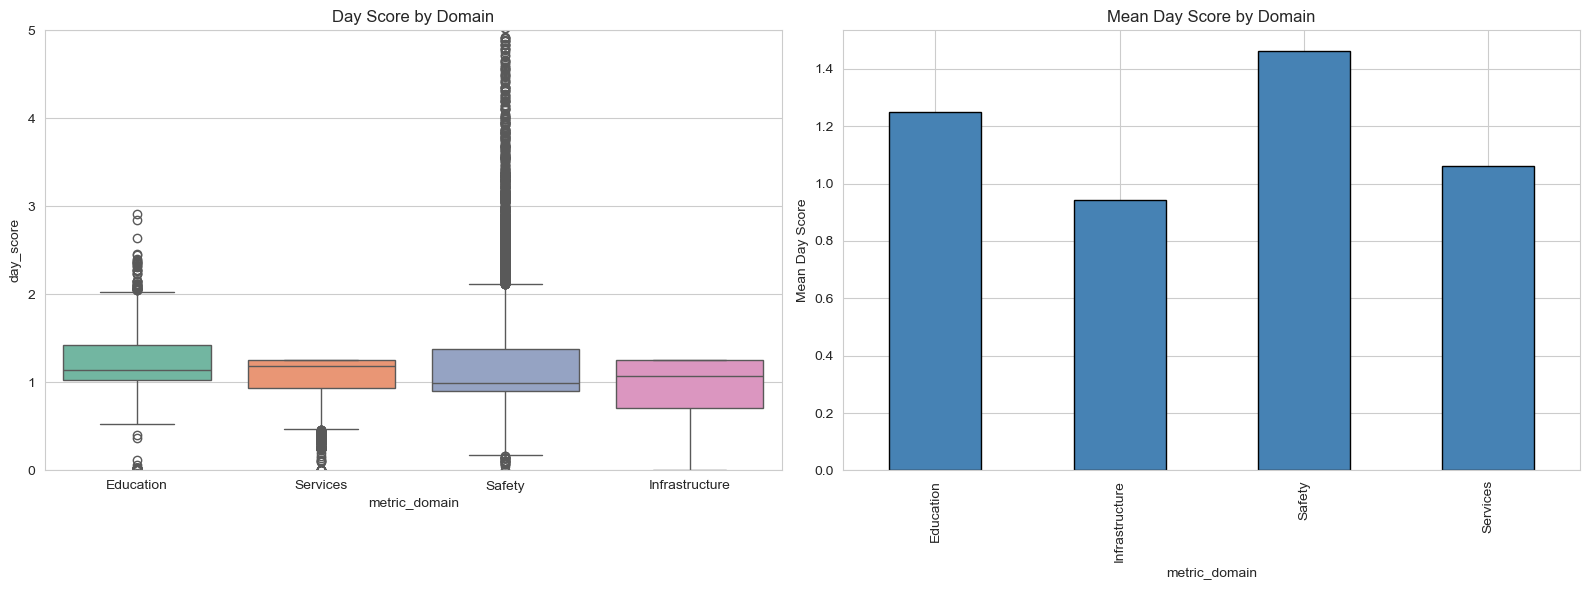


 Data Volume Imbalance
Median records per metric: 2897
  ⚠️ EMS RESPONSE TIME: 2462 records (85% of median)
  ⚠️ ON-TIME PERMIT REVIEWS: 2374 records (82% of median)


In [17]:
# SLICE 1: Day Score by Domain 
print(' Kruskal-Wallis: Day Score by Metric Domain')
domain_groups = [g['day_score'].dropna().values for _, g in cs.groupby('metric_domain') if len(g) >= 10]
stat, p = stats.kruskal(*domain_groups)
print(f'H-statistic: {stat:.4f}')
print(f'p-value:     {p:.6f}')
print(f'Significant: {p < 0.05}')

domain_means = cs.groupby('metric_domain')['day_score'].mean()
cv = domain_means.std() / domain_means.mean()
print(f'\nDomain means:')
print(domain_means.sort_values(ascending=False).round(4))
print(f'\nCV: {cv:.4f}')
print('⚠️ HIGH DISPARITY' if cv > 0.3 else '✓ Acceptable' if cv < 0.15 else '⚠️ MODERATE DISPARITY')

#  SLICE 2: Weekend vs Weekday 
print('\nMann-Whitney U: Weekend vs Weekday')
wk = cs[cs['is_weekend'] == 0]['day_score'].dropna()
we = cs[cs['is_weekend'] == 1]['day_score'].dropna()
stat_w, p_w = stats.mannwhitneyu(wk, we, alternative='two-sided')
print(f'Weekday mean: {wk.mean():.4f} (n={len(wk)})')
print(f'Weekend mean: {we.mean():.4f} (n={len(we)})')
print(f'U-statistic: {stat_w:.2f}, p-value: {p_w:.6f}')
print(f'Significant: {p_w < 0.05}')

#  Visualization 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=cs, x='metric_domain', y='day_score', ax=axes[0], palette='Set2')
axes[0].set_title('Day Score by Domain')
axes[0].set_ylim(0, 5)

cs.groupby('metric_domain')['day_score'].mean().plot(kind='bar', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('Mean Day Score by Domain')
axes[1].set_ylabel('Mean Day Score')

plt.tight_layout()
plt.show()

#  SLICE 3: Data volume per metric 
print('\n Data Volume Imbalance')
metric_counts = cs['metric_name'].value_counts()
median_count = metric_counts.median()
print(f'Median records per metric: {median_count:.0f}')
sparse = metric_counts[metric_counts < median_count * 0.9]
for m, c in sparse.items():
    print(f'  ⚠️ {m}: {c} records ({c/median_count*100:.0f}% of median)')

In [19]:
#  CHI-SQUARE: Are "below target" scores evenly distributed across domains? 
print('Chi-Square: Performance Flag by Domain')
cs['below_target'] = (cs['day_score'] < 1.0).astype(int)
contingency = pd.crosstab(cs['metric_domain'], cs['below_target'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency)
print(f'Chi-square statistic: {chi2:.4f}')
print(f'p-value: {p_chi:.6f}')
print(f'Degrees of freedom: {dof}')
print(f'Significant: {p_chi < 0.05}')
print(f'\n% of scores below target by domain:')
below_by_domain = cs.groupby('metric_domain')['below_target'].mean() * 100
print(below_by_domain.sort_values(ascending=False).round(1))

#  KS TEST: Compare Education vs Safety distributions 
print('\nKS Test: Education vs Safety Score Distribution')
edu_scores = cs[cs['metric_domain'] == 'Education']['day_score'].dropna()
safety_scores = cs[cs['metric_domain'] == 'Safety']['day_score'].dropna()
ks_stat, ks_p = stats.ks_2samp(edu_scores, safety_scores)
print(f'KS statistic: {ks_stat:.4f}')
print(f'p-value: {ks_p:.6f}')
print(f'Significant: {ks_p < 0.05}')
print(f'→ The two domains have {"DIFFERENT" if ks_p < 0.05 else "similar"} score distributions')

# LEVENE'S TEST: Variance equality across domains 
print('\n Levene Test: Score Variance Across Domains')
domain_data = [g['day_score'].dropna().values for _, g in cs.groupby('metric_domain')]
lev_stat, lev_p = stats.levene(*domain_data)
print(f'Levene statistic: {lev_stat:.4f}')
print(f'p-value: {lev_p:.6f}')
print(f'Significant: {lev_p < 0.05}')
print(f'→ Domains have {"UNEQUAL" if lev_p < 0.05 else "equal"} variance')

Chi-Square: Performance Flag by Domain
Chi-square statistic: 670.0614
p-value: 0.000000
Degrees of freedom: 3
Significant: True

% of scores below target by domain:
metric_domain
Infrastructure    28.4
Safety            27.9
Services          24.1
Education         12.6
Name: below_target, dtype: float64

KS Test: Education vs Safety Score Distribution
KS statistic: 0.3109
p-value: 0.000000
Significant: True
→ The two domains have DIFFERENT score distributions

 Levene Test: Score Variance Across Domains
Levene statistic: 392.1234
p-value: 0.000000
Significant: True
→ Domains have UNEQUAL variance


In [21]:
# MITIGATION 1: Domain-weighted sampling
print(' Mitigation 1: Inverse-Frequency Weighting')
domain_weights = 1 / cs['metric_domain'].value_counts(normalize=True)
cs['sample_weight'] = cs['metric_domain'].map(domain_weights)

print('Weight per domain (higher = boosted):')
for d in domain_weights.index:
    print(f'  {d}: {domain_weights[d]:.2f}x')
print('→ Education gets ~3.5x weight to compensate for underrepresentation')

# MITIGATION 2: Weekend/weekday separation
print('\n Mitigation 2: Weekend/Weekday Separation')
for domain in cs['metric_domain'].unique():
    d = cs[cs['metric_domain'] == domain]
    wk_mean = d[d['is_weekend'] == 0]['day_score'].mean()
    we_mean = d[d['is_weekend'] == 1]['day_score'].mean()
    diff = abs(wk_mean - we_mean) / wk_mean * 100 if wk_mean > 0 else 0
    flag = ' ⚠️ >10% gap' if diff > 10 else ' ✓'
    print(f'  {domain}: weekday={wk_mean:.3f}, weekend={we_mean:.3f}, diff={diff:.1f}%{flag}')

# MITIGATION 3: Time-based stratified split
print('\n Mitigation 3: Time-Based Split (stratified by domain)')
cs_sorted = cs.sort_values('score_calculated_ts')
n = len(cs_sorted)
train = cs_sorted.iloc[:int(n*0.70)]
val   = cs_sorted.iloc[int(n*0.70):int(n*0.85)]
test  = cs_sorted.iloc[int(n*0.85):]

print(f'Train: {len(train)} | Val: {len(val)} | Test: {len(test)}')
print('\nDomain % across splits:')
for name, split in [('Full', cs), ('Train', train), ('Val', val), ('Test', test)]:
    edu_pct = (split['metric_domain'] == 'Education').mean() * 100
    print(f'  {name}: Education={edu_pct:.1f}%')
print('✓ Time-based split preserves temporal order (no data leakage)')

 Mitigation 1: Inverse-Frequency Weighting
Weight per domain (higher = boosted):
  Infrastructure: 3.23x
  Services: 3.29x
  Safety: 3.37x
  Education: 11.23x
→ Education gets ~3.5x weight to compensate for underrepresentation

 Mitigation 2: Weekend/Weekday Separation
  Education: weekday=1.238, weekend=1.300, diff=5.0% ✓
  Services: weekday=1.057, weekend=1.071, diff=1.3% ✓
  Safety: weekday=1.472, weekend=1.428, diff=3.0% ✓
  Infrastructure: weekday=0.940, weekend=0.957, diff=1.9% ✓

 Mitigation 3: Time-Based Split (stratified by domain)
Train: 45530 | Val: 9757 | Test: 9757

Domain % across splits:
  Full: Education=8.9%
  Train: Education=8.7%
  Val: Education=8.9%
  Test: Education=9.7%
✓ Time-based split preserves temporal order (no data leakage)
